In [2]:
import sys
import os

# Add the root directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Import classifiers
from weighted_model import (
    FairTeacherStudentClassifier,
    TeacherStudentClassifier
)

# Import curriculum models
from curriculum_models import (
    CurriculumStudentTeacher,
    WeightedCurriculumStudentTeacher
)

# Import helpers
from helpers import (
    CurriculumHelper,
    FairnessEvaluatorHelper
)
from sklearn.linear_model import SGDClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from fairlearn.datasets import fetch_adult
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
np.random.seed(41) # Set seed for reproducibility
%load_ext autoreload
%autoreload 2

In [3]:
data = fetch_adult(as_frame=True)
df = data.frame
print(len(df))
df.head()


48842


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


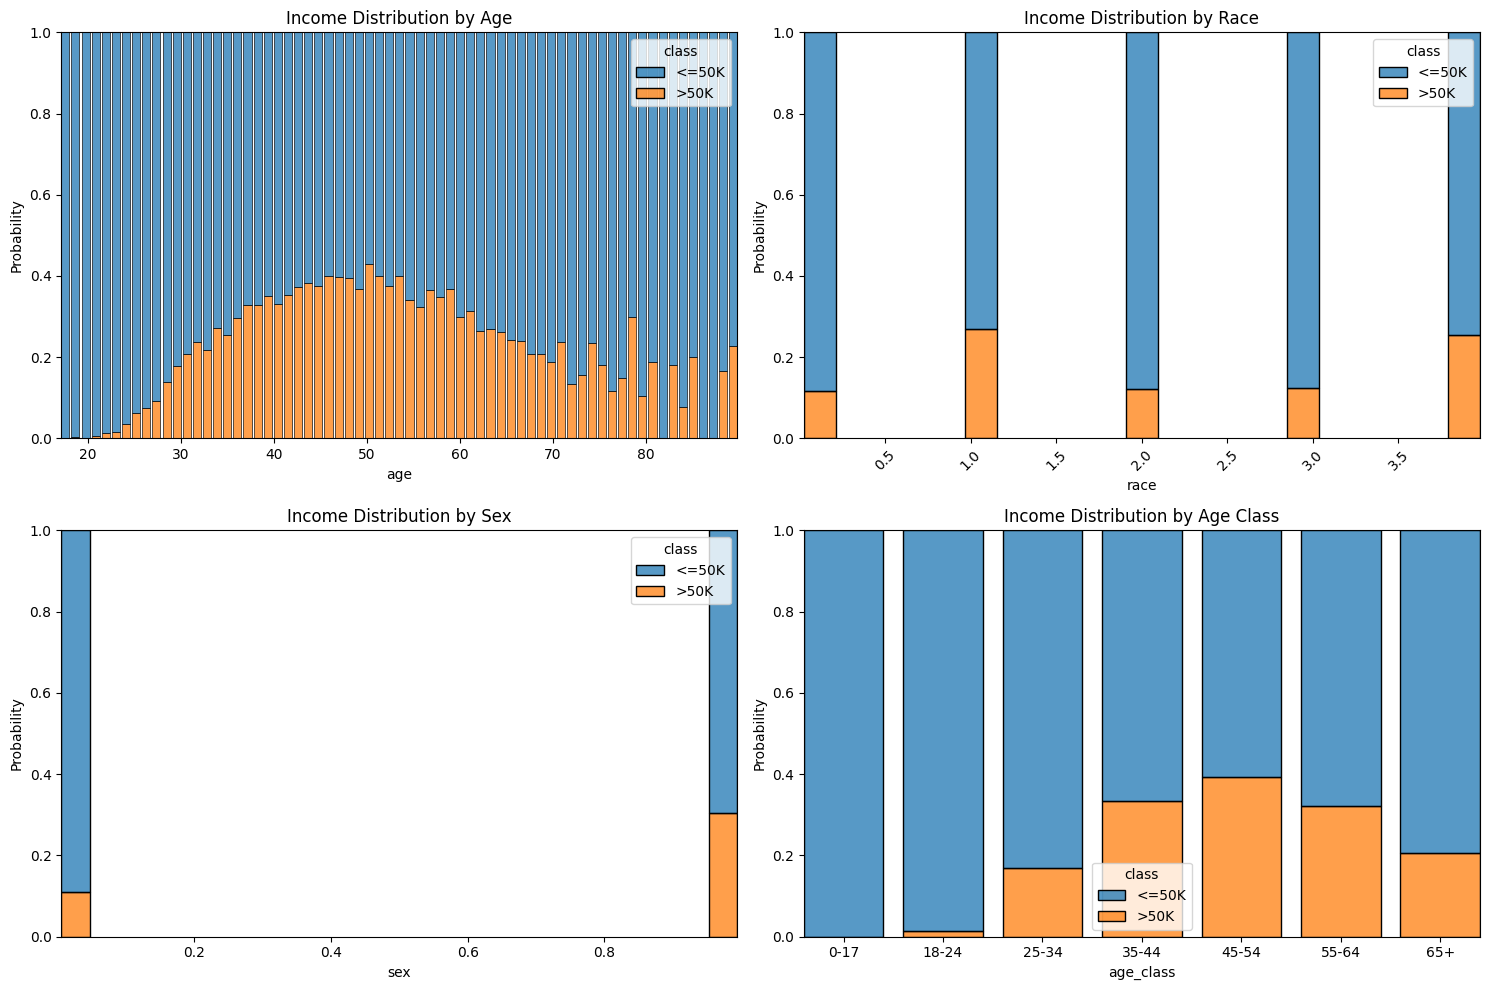

In [14]:
"""Plots multiple graphs showing the distribution of income by different features."""
df['age_class'] = pd.cut(df['age'], bins=[0, 18, 24, 34, 44, 54, 64, float('inf')],
                         labels=['0-17', '18-24', '25-34', '35-44', '45-54', '55-64', '65+'])


fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sns.histplot(data=df, x='age', hue='class', stat='probability', multiple='fill', shrink=.8, ax=axes[0, 0])
axes[0, 0].set_title("Income Distribution by Age")

sns.histplot(data=df, x='race', hue='class', stat='probability', multiple='fill', shrink=.8, ax=axes[0, 1])
axes[0, 1].set_title("Income Distribution by Race")
axes[0, 1].tick_params(axis='x', rotation=45)

sns.histplot(data=df, x='sex', hue='class', stat='probability', multiple='fill', shrink=.8, ax=axes[1, 0])
axes[1, 0].set_title("Income Distribution by Sex")

sns.histplot(data=df, x='age_class', hue='class', stat='probability', multiple='fill', shrink=.8, ax=axes[1, 1])
axes[1, 1].set_title("Income Distribution by Age Class")

plt.tight_layout()
plt.show()


# Age class Sensitive feature

In [16]:
# Load dataset
data = fetch_adult(as_frame=True)
df = data.frame

df['age_class'] = pd.cut(df['age'], bins=[0, 18, 24, 34, 44, 54, 64, float('inf')],
                         labels=['0-17', '18-24', '25-34', '35-44', '45-54', '55-64', '65+'])

# Preprocessing: Encode categorical variables
label_encoders = {}
for col in ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'age_class']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Features and labels
X = df.drop(columns=['class'])
y = (df['class'] == '>50K').astype(int)  # Binary target: 1 if >50K, else 0
z = df['age_class']  # Sensitive attribute

# Stratified K-Fold Split
# Stratified K-Fold is used instead of regular K-Fold to ensure that each fold maintains 
# the same distribution of the sensetive variable (z). This is crucial when dealing with imbalanced datasets,
# as it prevents some folds from having disproportionately higher or lower occurrences of the target classes.
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

folds = []
for fold_idx, (train_idx, test_idx) in enumerate(skf.split(X, z)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    z_train, z_test = z.iloc[train_idx], z.iloc[test_idx]
    folds.append((X_train, X_test, y_train, y_test, z_train, z_test))

In [30]:
# Experiment 
# 


def train_and_predict_with_sensitive_feature(folds, sensitive_feature):
    # Dictionary to store predictions
    predictions = {"fairness_curriculum_SGD": [], "fairness_curriculum_SGD_asc": [],
                "weighted_curriculum_mode_0": [], "weighted_curriculum_mode_1": [], "weighted_curriculum_mode_2": [],
                "fair_classifier_split_mode_1": [], "diff_asc_model": [], "curriculum_model": [],
                "difficulty_based_model": [], "SGD_model": [], "student_teacher": [], "rf_classifier": []}

    for fold_idx, (X_train, X_test, y_train, y_test, z_train, z_test) in enumerate(folds):

        # Initialize models
        # CurriculumStudentTeacher SGD with different trasnform functions
        fairness_curriculum_SGD = CurriculumStudentTeacher(teacher=RandomForestClassifier(), student = SGDClassifier(average=True, loss="log_loss"),transform_func=lambda X, y_prob, n_splits: CurriculumHelper.split_by_sensitive_feature_and_confidence(X, y_prob, sensitive_feature=sensitive_feature))
        fairness_curriculum_SGD_asc = CurriculumStudentTeacher(teacher=RandomForestClassifier(), student = SGDClassifier(average=True, loss="log_loss"), transform_func=lambda X, y_prob, n_splits: CurriculumHelper.split_by_sensitive_feature_and_confidence(X, y_prob, sensitive_feature=sensitive_feature, ascending=True))

        # WeightedCurriculumStudentTeacher with different modes for sample weights calculation
        weighted_curriculum_model_mode_0 = WeightedCurriculumStudentTeacher(teacher=RandomForestClassifier(), student = SGDClassifier(average=True, loss="log_loss"), transform_func=lambda X, y_prob, n_splits: CurriculumHelper.split_by_sensitive_feature_and_confidence(X, y_prob, sensitive_feature=sensitive_feature))
        weighted_curriculum_model_mode_1 = WeightedCurriculumStudentTeacher(teacher=RandomForestClassifier(), student = SGDClassifier(average=True, loss="log_loss"), transform_func=lambda X, y_prob, n_splits: CurriculumHelper.split_by_sensitive_feature_and_confidence(X, y_prob, sensitive_feature=sensitive_feature))
        weighted_curriculum_model_mode_2 = WeightedCurriculumStudentTeacher(teacher=RandomForestClassifier(), student = SGDClassifier(average=True, loss="log_loss"), transform_func=lambda X, y_prob, n_splits: CurriculumHelper.split_by_sensitive_feature_and_confidence(X, y_prob, sensitive_feature=sensitive_feature))

        # FairTeacherStudentClassifier the most succesfull clasifier from the previous experiments with weights
        fair_classifier_split_mode_1 = FairTeacherStudentClassifier(teacher=RandomForestClassifier(), student=SGDClassifier(average=True, loss="log_loss"), split_data=False)

        # Multiple curriculum models for reference
        curriculum_model = CurriculumStudentTeacher(teacher=RandomForestClassifier(), student = SGDClassifier(average=True, loss="log_loss"), transform_func= CurriculumHelper.split_into_parts, n_splits=6)	

        difficulty_based_model = CurriculumStudentTeacher(teacher=RandomForestClassifier(), student = SGDClassifier(average=True, loss="log_loss"), transform_func= CurriculumHelper.split_into_difficulty_parts, n_splits=6)

        diff_asc_model = CurriculumStudentTeacher(teacher=RandomForestClassifier(), student = SGDClassifier(average=True, loss="log_loss"), transform_func= CurriculumHelper.split_into_difficulty_parts_asc, n_splits=6)

        #Student Teacher models for reference
        student_teacher = TeacherStudentClassifier(teacher=RandomForestClassifier(), student=SGDClassifier(average=True, loss="log_loss"))

        #randomForrest for reference
        rf_classifier = RandomForestClassifier()

        #SGD for reference
        sgd_model = SGDClassifier(average=True, loss="log_loss")


        print(f"Training on fold {fold_idx + 1}...")
        
        # Train classifiers
        diff_asc_model.fit(X_train.copy(deep=False), y_train.copy(deep=False))
        fairness_curriculum_SGD.fit(X_train.copy(deep=False), y_train.copy(deep=False))
        fairness_curriculum_SGD_asc.fit(X_train.copy(deep=False), y_train.copy(deep=False))
        weighted_curriculum_model_mode_0.fit(X_train.copy(deep=False), y_train.copy(deep=False), z_train.copy(deep=False), mode=0)
        weighted_curriculum_model_mode_1.fit(X_train.copy(deep=False), y_train.copy(deep=False), z_train.copy(deep=False), mode=1)
        weighted_curriculum_model_mode_2.fit(X_train.copy(deep=False), y_train.copy(deep=False), z_train.copy(deep=False), mode=2)
        fair_classifier_split_mode_1.fit(X_train.copy(deep=False), y_train.copy(deep=False), z_train.copy(deep=False), mode=1)
        sgd_model.fit(X_train.copy(deep=False), y_train.copy(deep=False))
        difficulty_based_model.fit(X_train.copy(deep=False), y_train.copy(deep=False))
        curriculum_model.fit(X_train.copy(deep=False), y_train.copy(deep=False))
        student_teacher.fit(X_train.copy(deep=False), y_train.copy(deep=False))
        rf_classifier.fit(X_train.copy(deep=False), y_train.copy(deep=False))
        
        print(f"Predicting on fold {fold_idx + 1}...")
        predictions["fairness_curriculum_SGD"].append(fairness_curriculum_SGD.predict(X_test))
        predictions["fairness_curriculum_SGD_asc"].append(fairness_curriculum_SGD_asc.predict(X_test))
        predictions["weighted_curriculum_mode_0"].append(weighted_curriculum_model_mode_0.predict(X_test))
        predictions["weighted_curriculum_mode_1"].append(weighted_curriculum_model_mode_1.predict(X_test))
        predictions["weighted_curriculum_mode_2"].append(weighted_curriculum_model_mode_2.predict(X_test))
        predictions["fair_classifier_split_mode_1"].append(fair_classifier_split_mode_1.predict(X_test))
        predictions["diff_asc_model"].append(diff_asc_model.predict(X_test))
        predictions["curriculum_model"].append(curriculum_model.predict(X_test))
        predictions["difficulty_based_model"].append(difficulty_based_model.predict(X_test))
        predictions["SGD_model"].append(sgd_model.predict(X_test))
        predictions["student_teacher"].append(student_teacher.predict(X_test))
        predictions["rf_classifier"].append(rf_classifier.predict(X_test))
        
        print(f"Fold {fold_idx + 1} complete.\n")

    return predictions



In [ ]:
predictions = train_and_predict_with_sensitive_feature(folds, sensitive_feature='age_class')

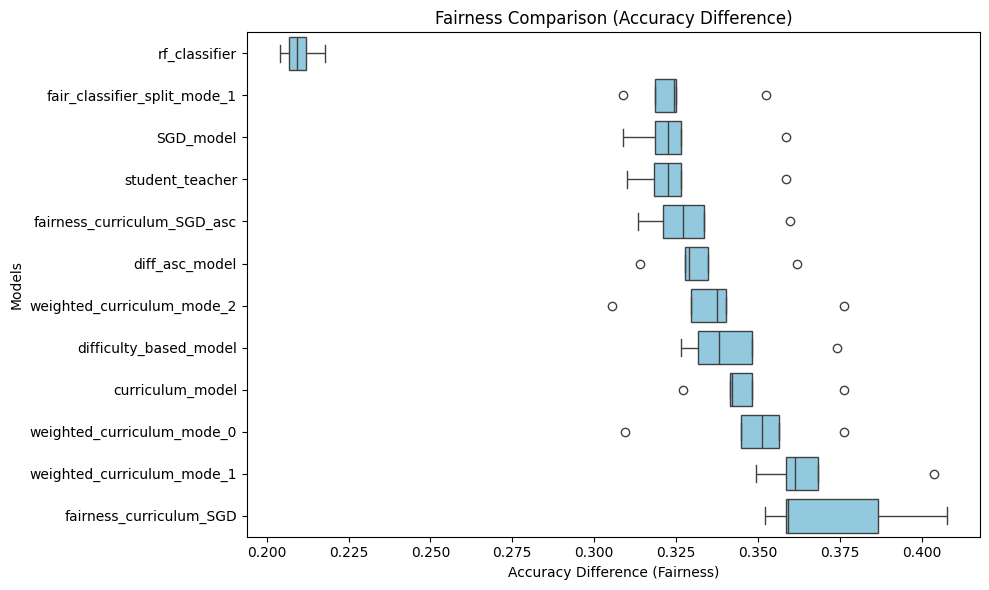

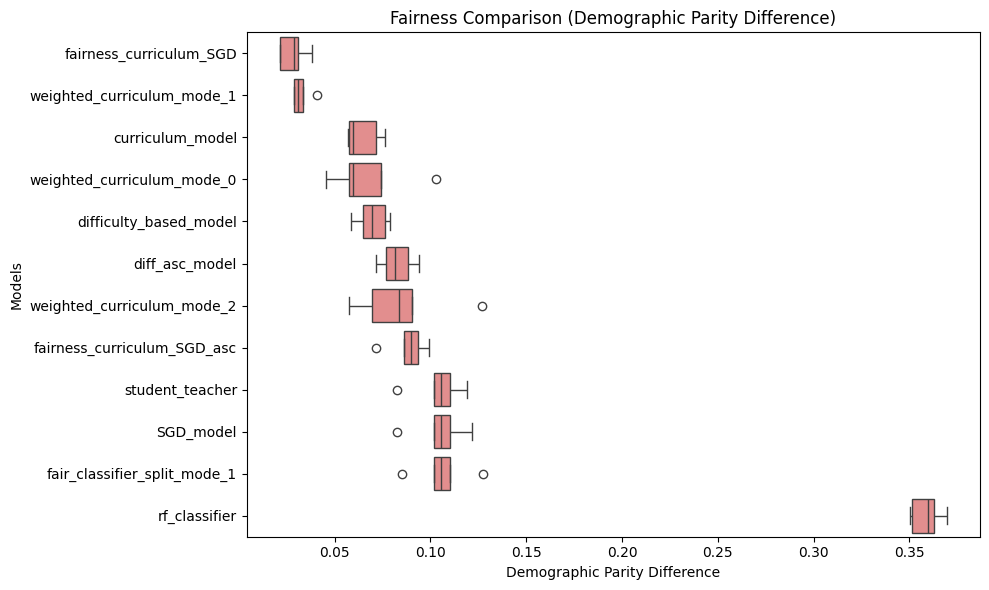

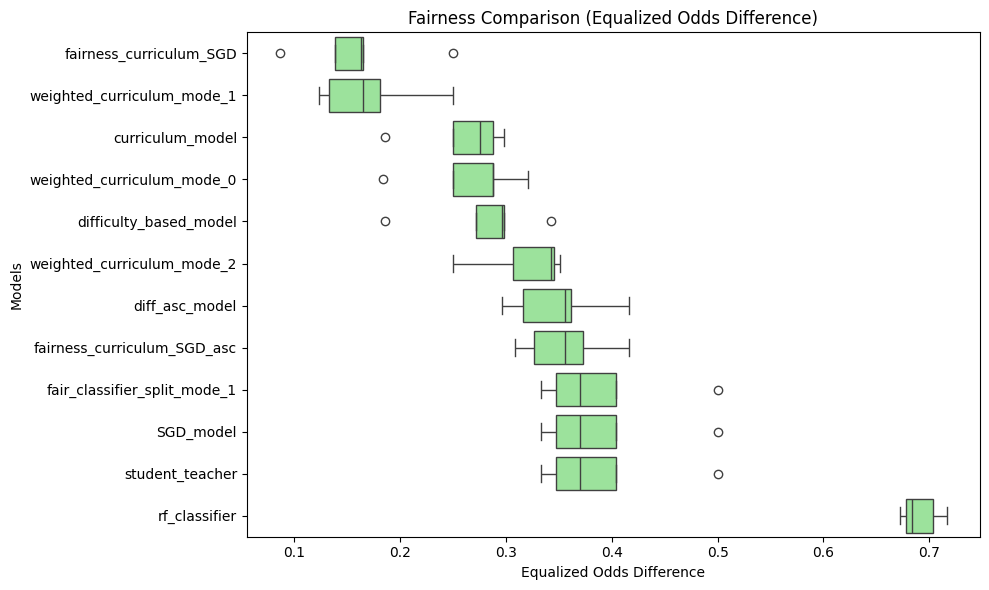

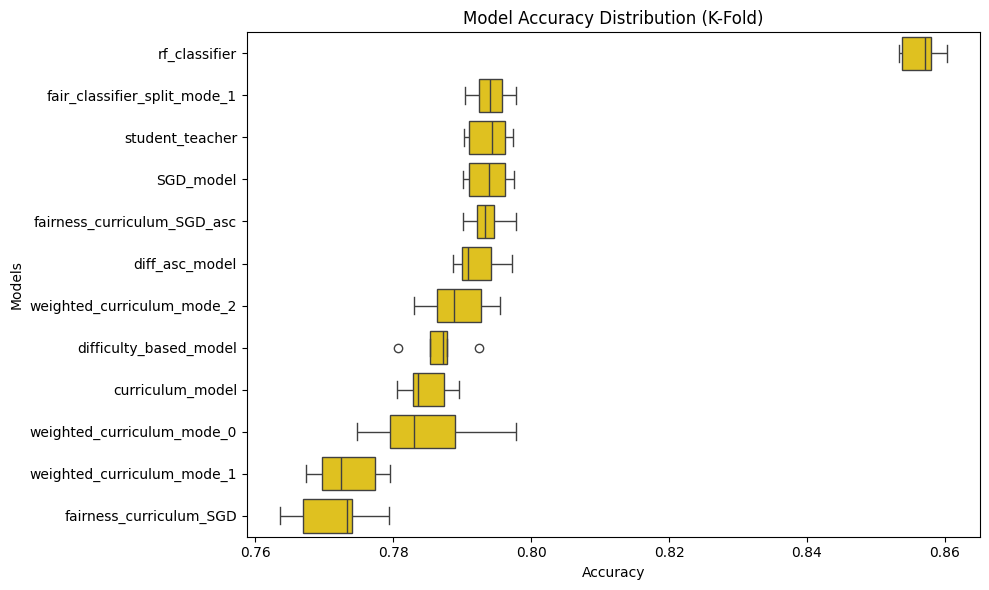

In [20]:
# Instantiate the fairness evaluator
evaluator = FairnessEvaluatorHelper(folds, predictions)

# Compute all fairness metrics
evaluator.compute_fairness_metrics()

# Plot sorted fairness metrics
evaluator.plot_accuracy_differences()
evaluator.plot_demographic_parity()
evaluator.plot_equalized_odds()
evaluator.plot_accuracies()


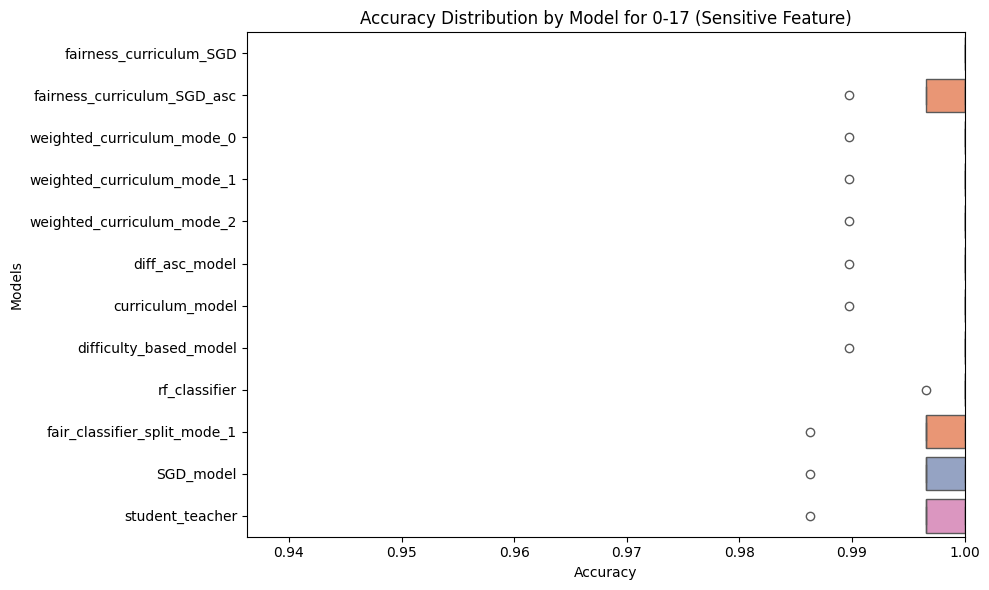

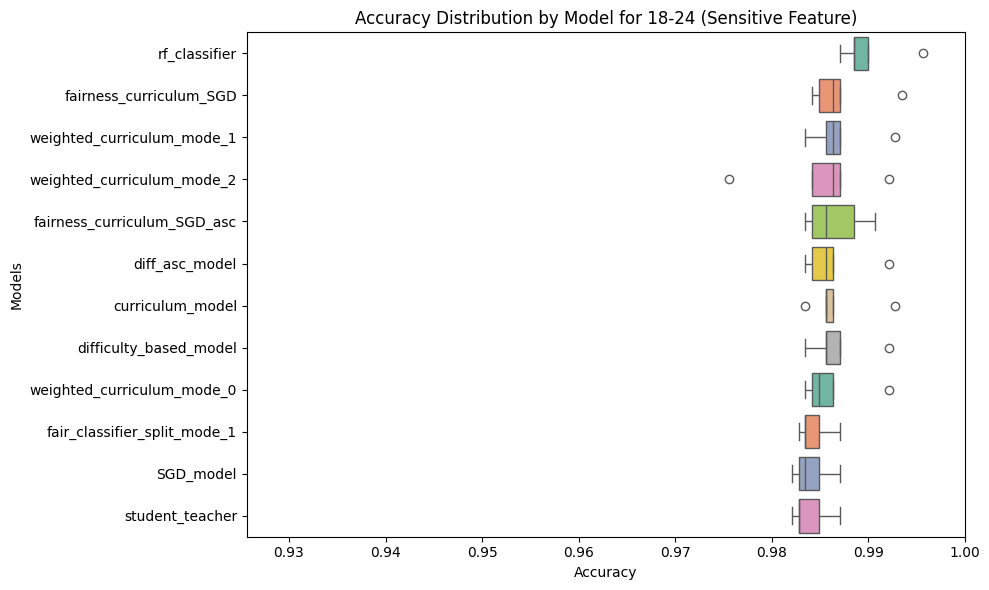

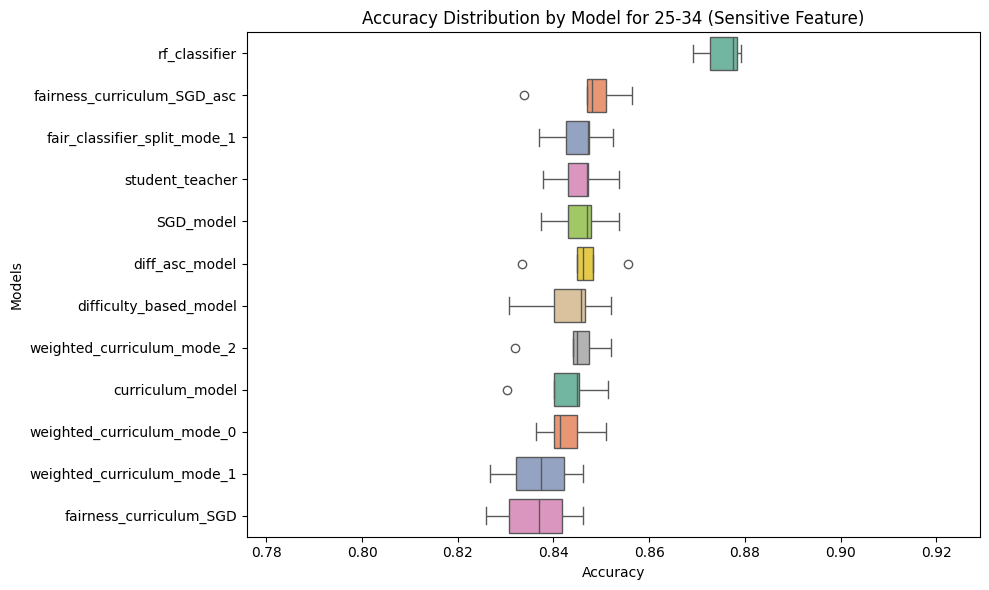

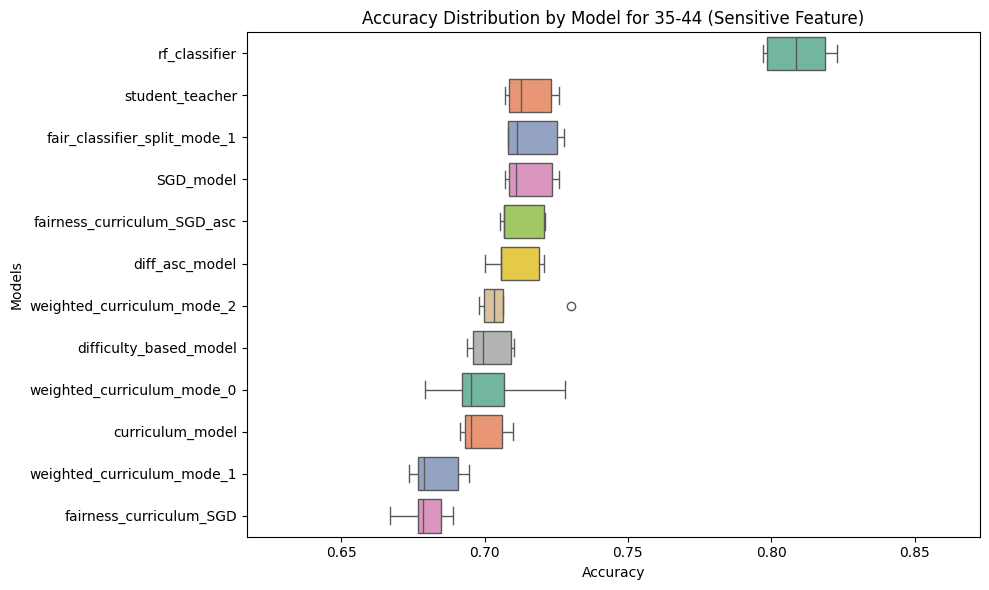

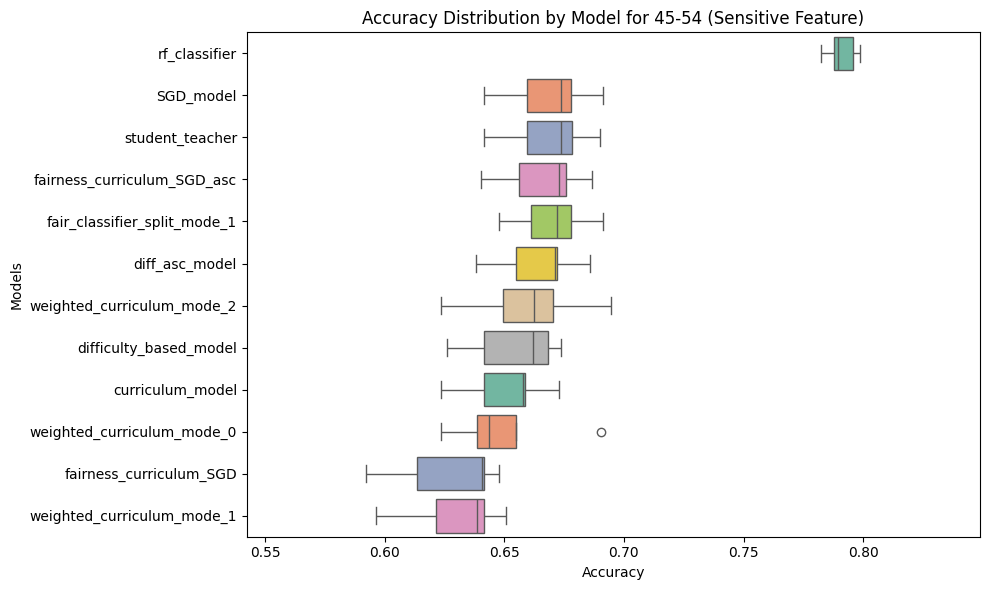

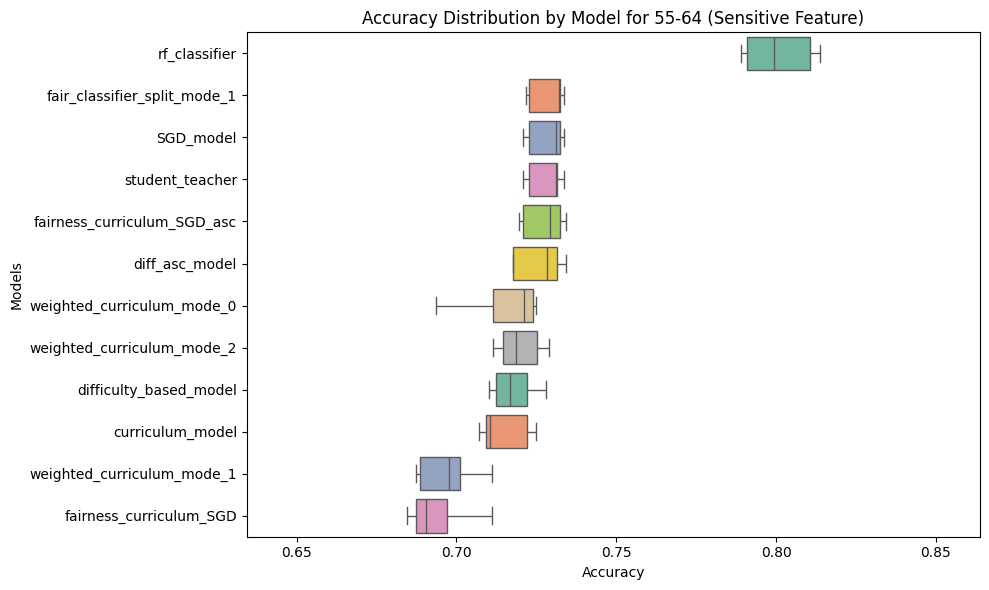

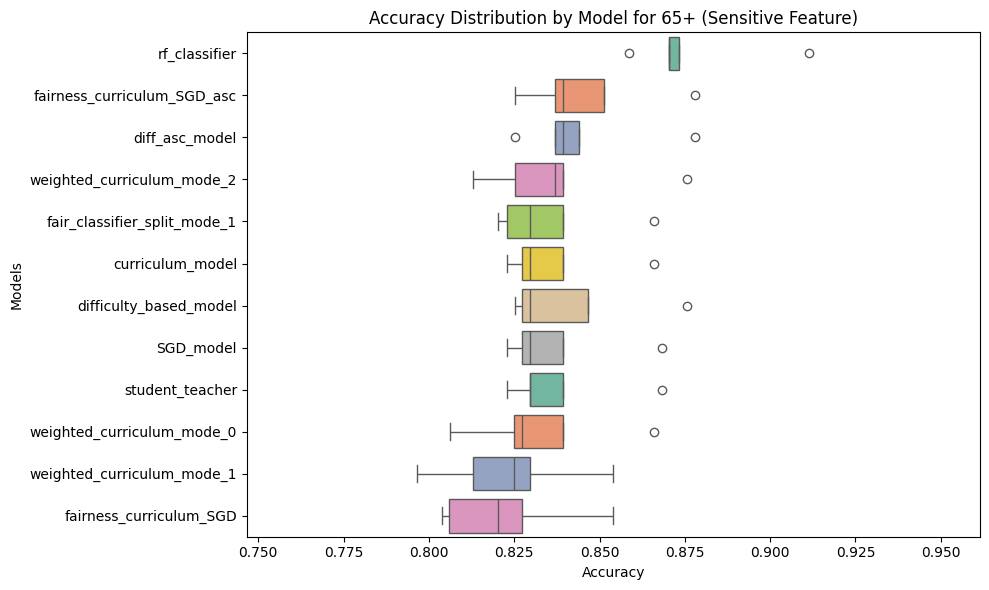

In [22]:
# Plot per-group accuracy distributions
evaluator.plot_group_accuracies(label_encoder=label_encoders['age_class'])

# Age class and Gender as a Sensitive feature

In [31]:
data = fetch_adult(as_frame=True)
df = data.frame

# Create 'age_class' column
df['age_class'] = pd.cut(df['age'], bins=[0, 18, 24, 34, 44, 54, 64, float('inf')],
                         labels=['0-17', '18-24', '25-34', '35-44', '45-54', '55-64', '65+'])

# Combine 'gender' (sex) and 'age_class' into a new feature 'gender_age_class'
df['gender_age_class'] = df['sex'].astype(str) + "_" + df['age_class'].astype(str)

# To confirm the sensitive feature, you can check the distribution of the combined sensitive feature
print("Distribution of 'gender_age_class' sensitive feature:")
print(df['gender_age_class'].value_counts())

df.drop(columns=['age_class'], inplace=True)

# Preprocessing: Encode categorical variables
label_encoders = {}
for col in ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'gender_age_class']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le



# Features and labels
X = df.drop(columns=['class'])
y = (df['class'] == '>50K').astype(int)  # Binary target: 1 if >50K, else 0
z = df['gender_age_class']  # Combined sensitive attribute (gender + age_class)

# Stratified K-Fold Split (stratified by combined sensitive feature 'gender_age_class')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

folds = []
for fold_idx, (train_idx, test_idx) in enumerate(skf.split(X, z)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    z_train, z_test = z.iloc[train_idx], z.iloc[test_idx]
    folds.append((X_train, X_test, y_train, y_test, z_train, z_test))



Distribution of 'gender_age_class' sensitive feature:
gender_age_class
Male_35-44      8647
Male_25-34      8408
Male_45-54      6214
Female_25-34    4169
Male_18-24      3878
Female_35-44    3546
Male_55-64      3373
Female_18-24    3097
Female_45-54    2557
Female_55-64    1409
Male_65+        1395
Male_0-17        735
Female_0-17      722
Female_65+       692
Name: count, dtype: int64


In [32]:
predictions = train_and_predict_with_sensitive_feature(folds, sensitive_feature='gender_age_class')

Training on fold 1...
Min accuracy group: 2
Min accuracy group: 2
Predicting on fold 1...
Fold 1 complete.

Training on fold 2...
Min accuracy group: 11
Min accuracy group: 12
Predicting on fold 2...
Fold 2 complete.

Training on fold 3...
Min accuracy group: 2
Min accuracy group: 10
Predicting on fold 3...
Fold 3 complete.

Training on fold 4...
Min accuracy group: 4
Min accuracy group: 11
Predicting on fold 4...
Fold 4 complete.

Training on fold 5...
Min accuracy group: 11
Min accuracy group: 11
Predicting on fold 5...
Fold 5 complete.



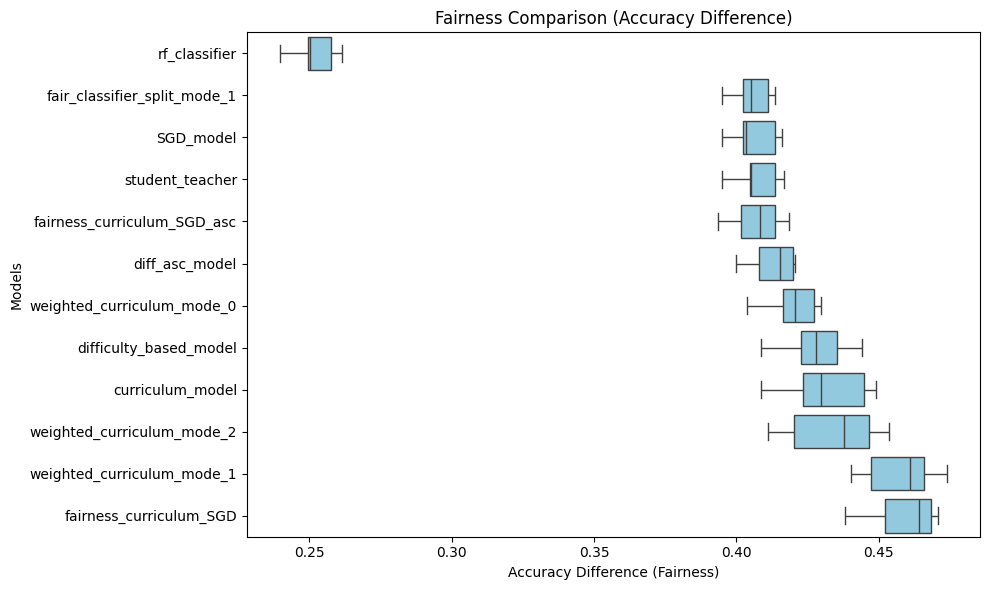

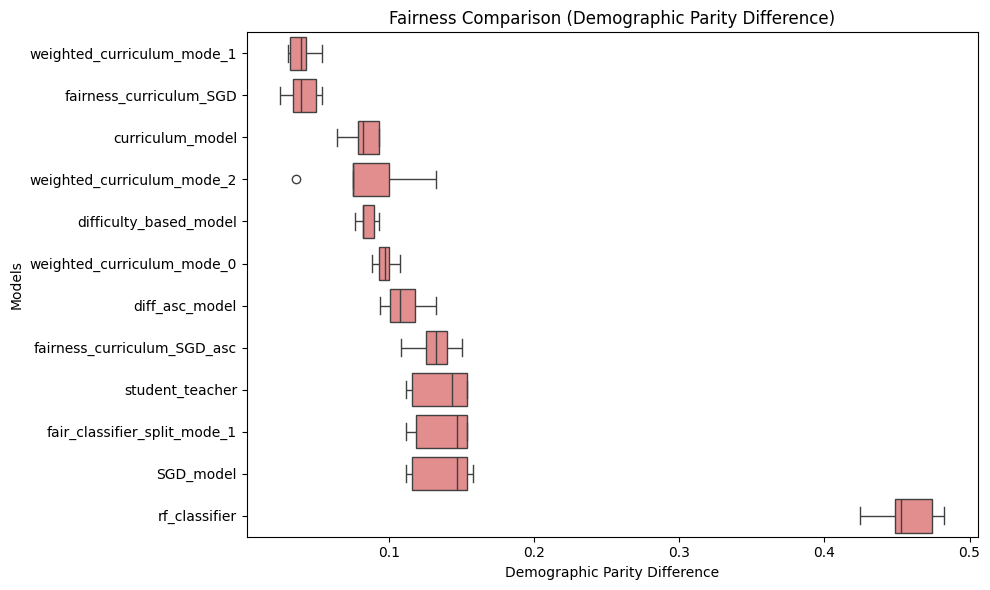

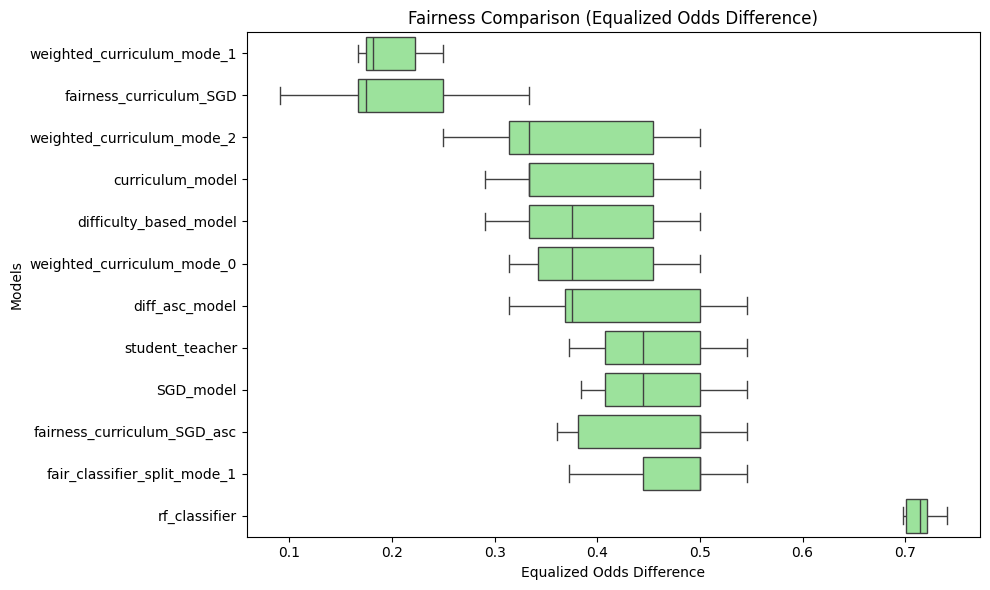

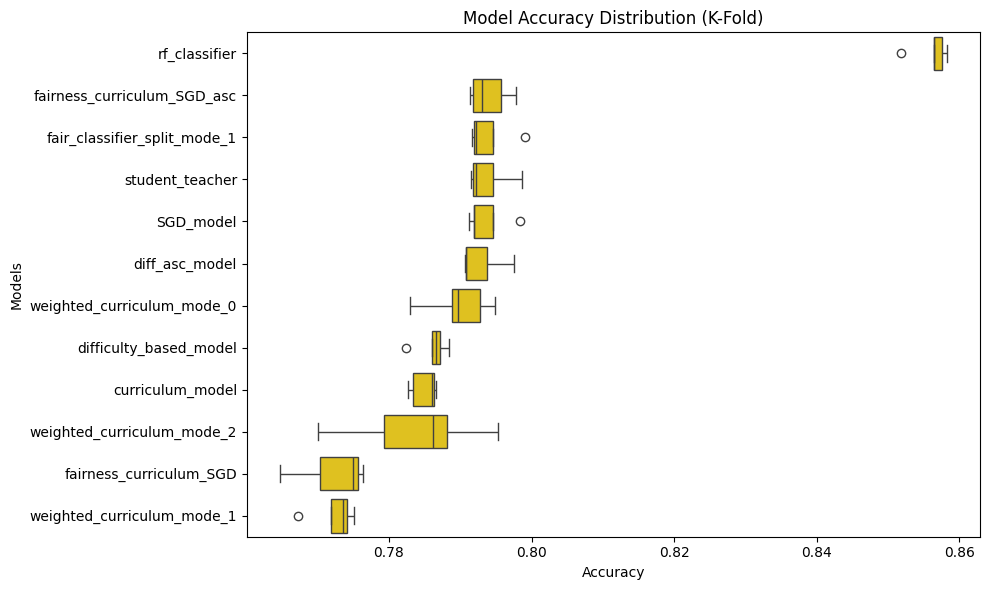

In [33]:
# Instantiate the fairness evaluator
evaluator = FairnessEvaluatorHelper(folds, predictions)

# Compute all fairness metrics
evaluator.compute_fairness_metrics()

# Plot sorted fairness metrics
evaluator.plot_accuracy_differences()
evaluator.plot_demographic_parity()
evaluator.plot_equalized_odds()
evaluator.plot_accuracies()

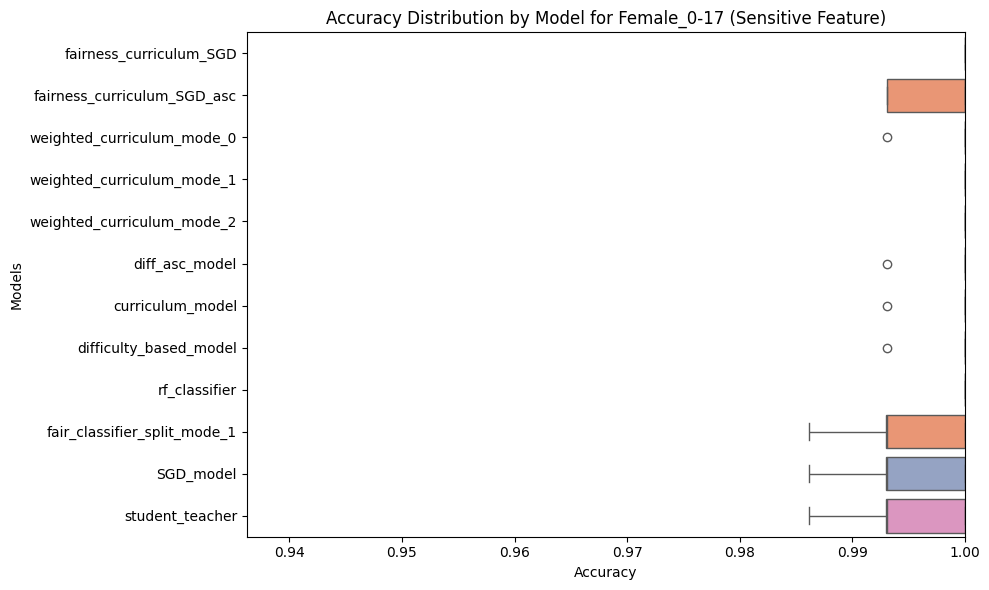

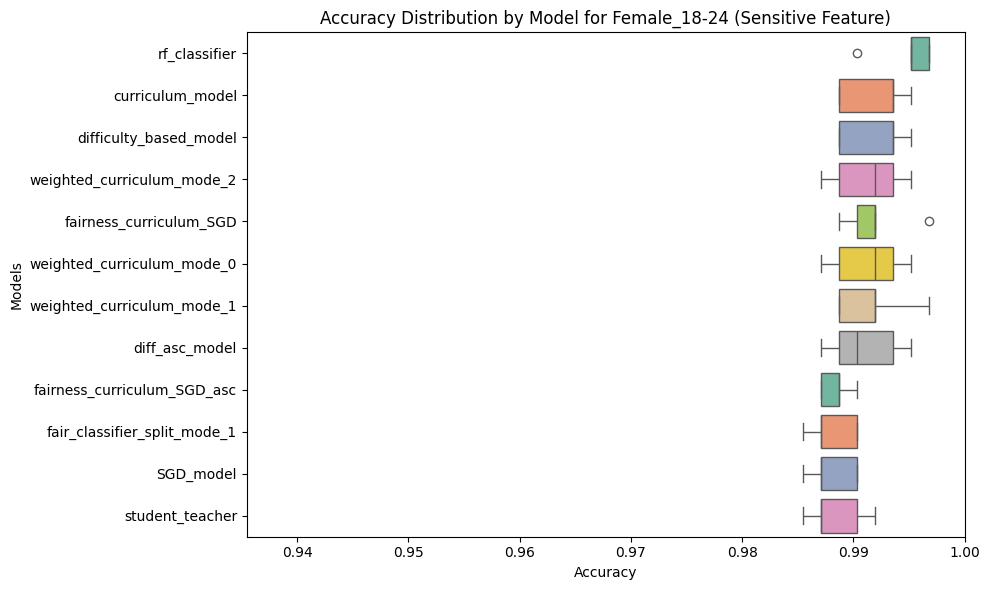

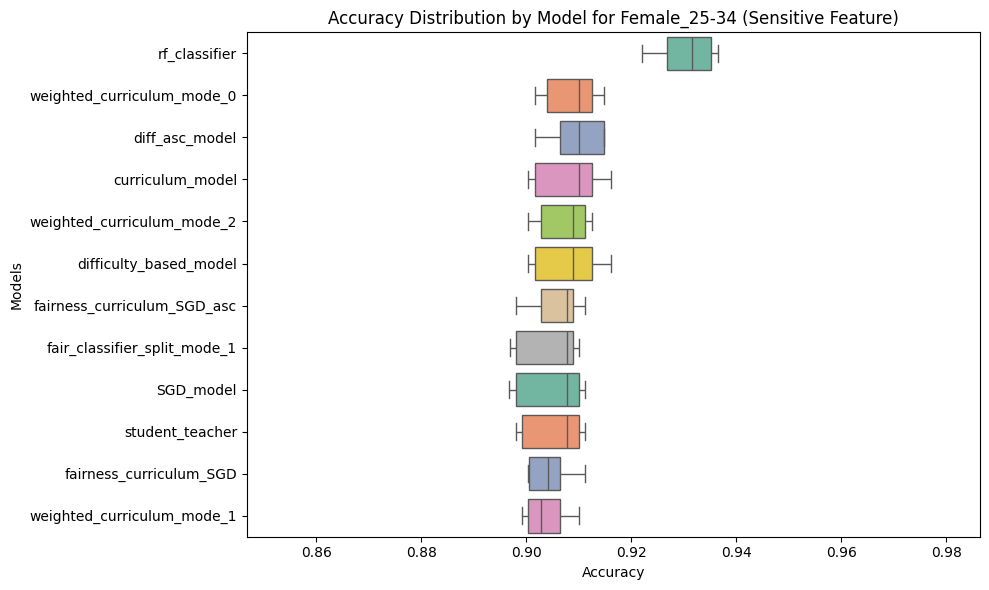

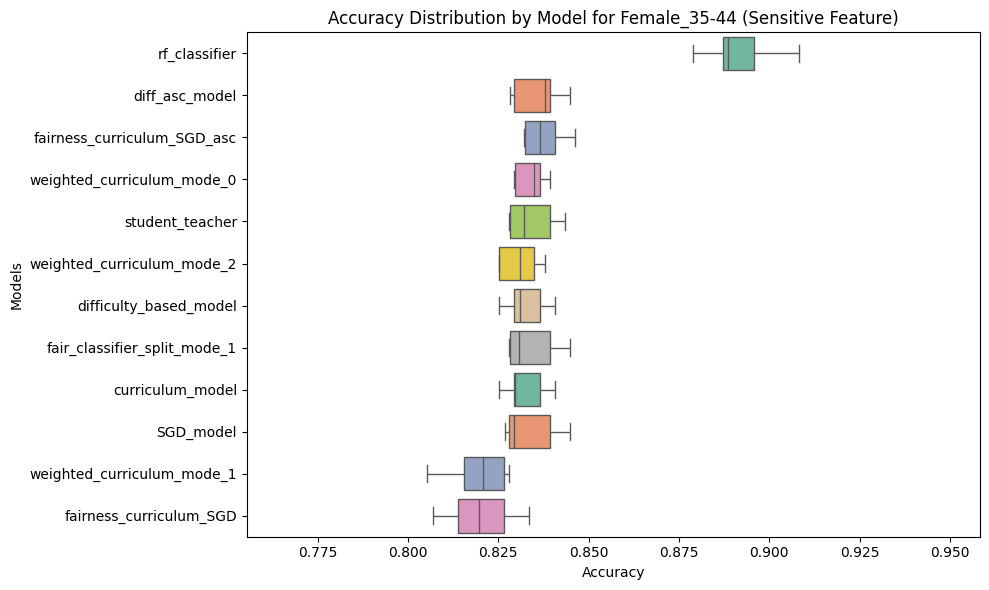

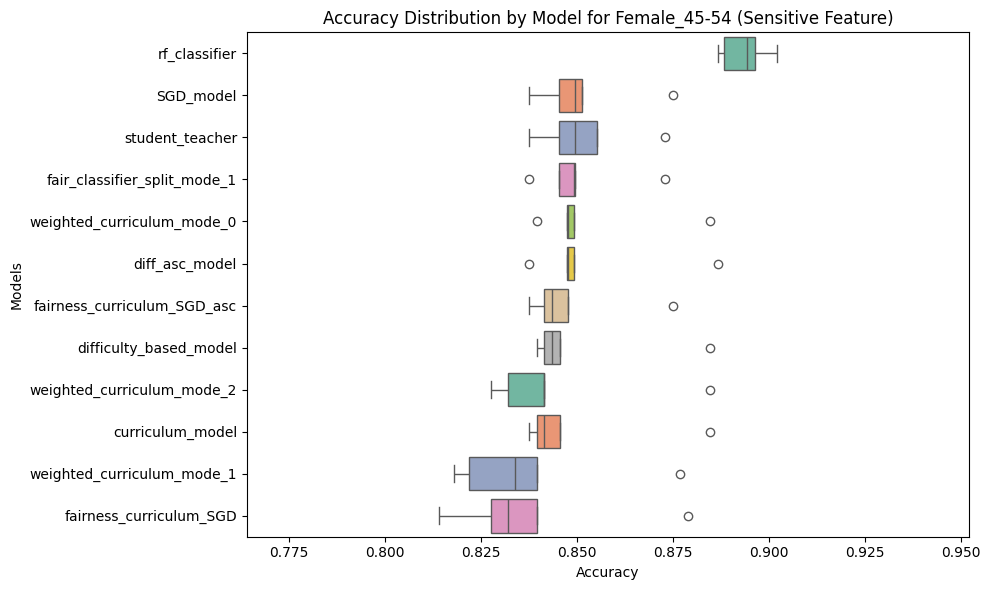

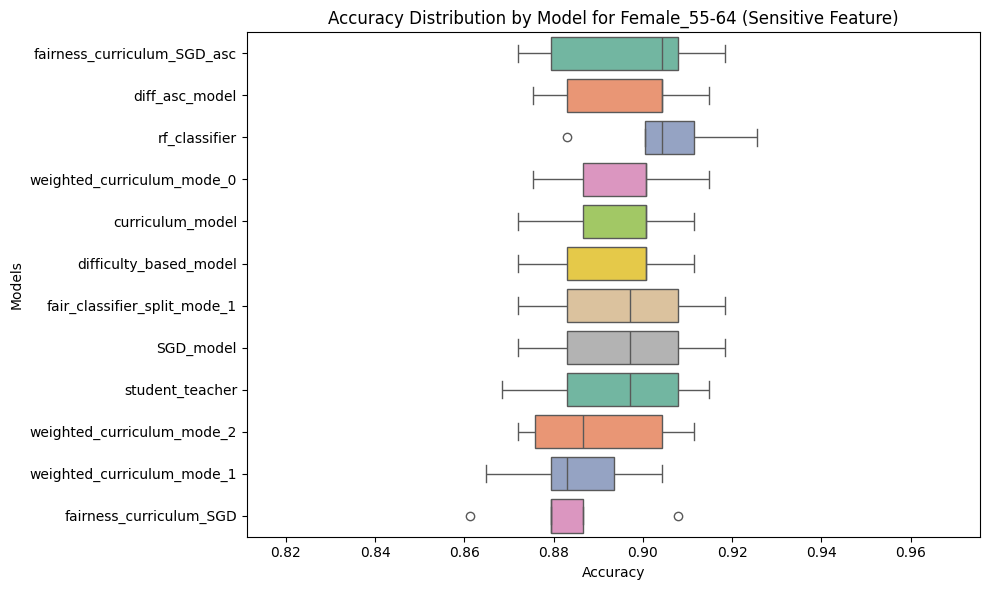

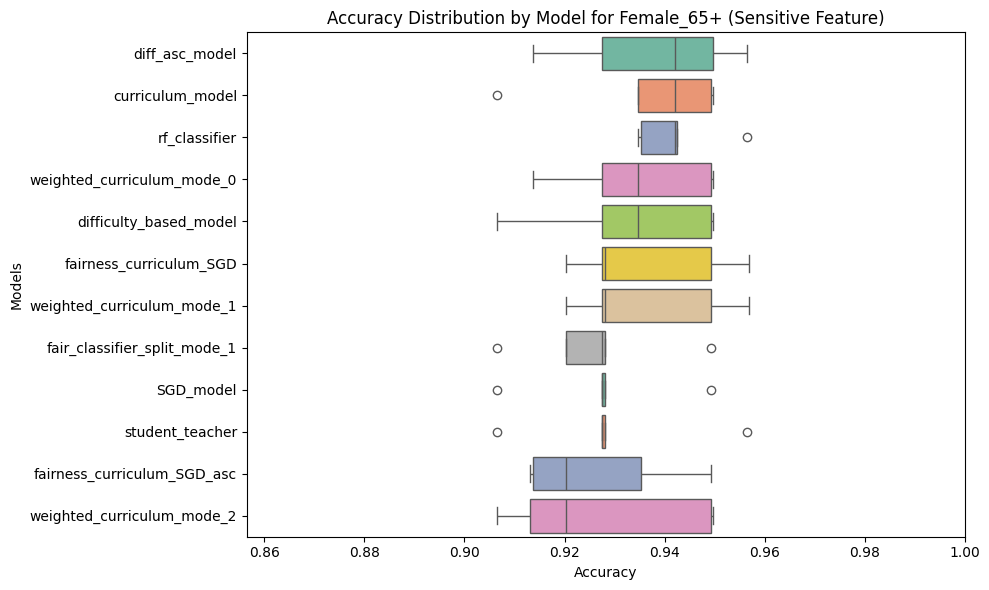

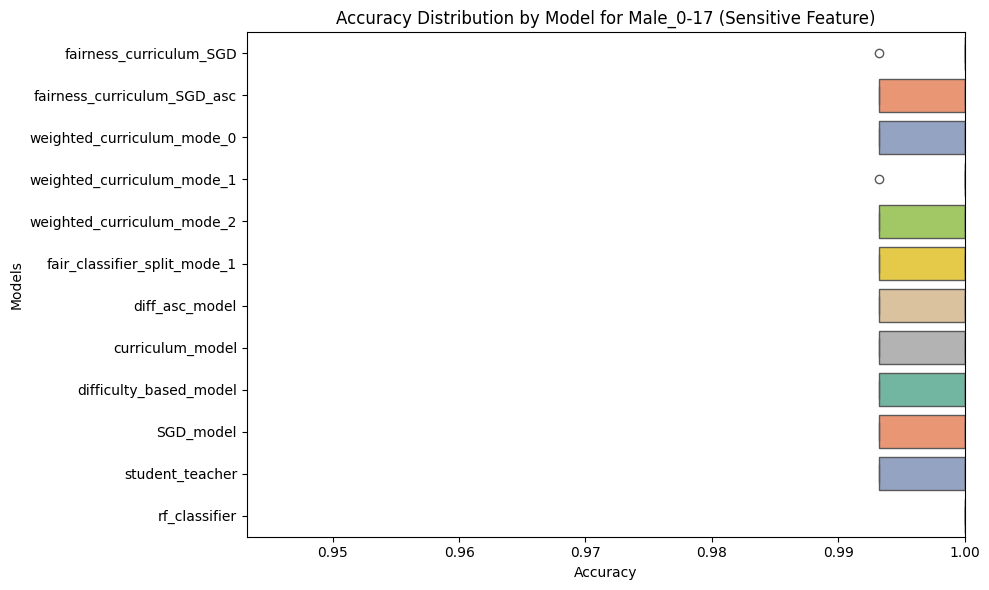

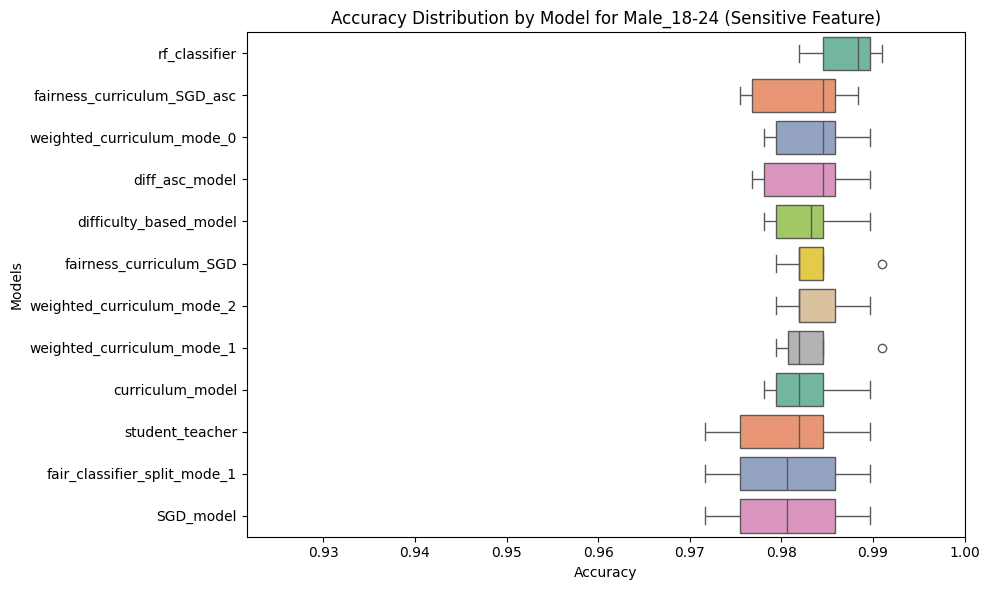

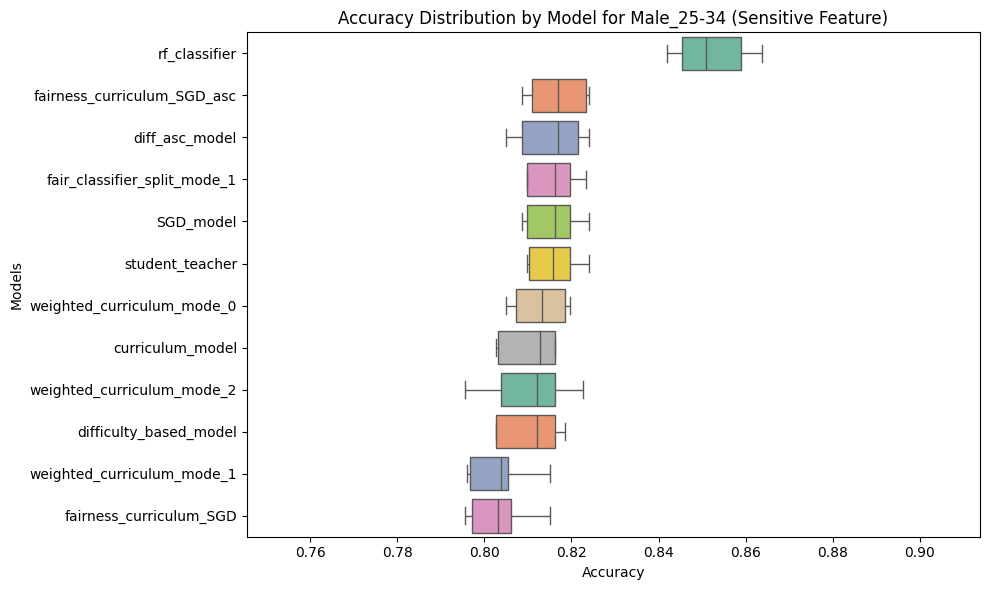

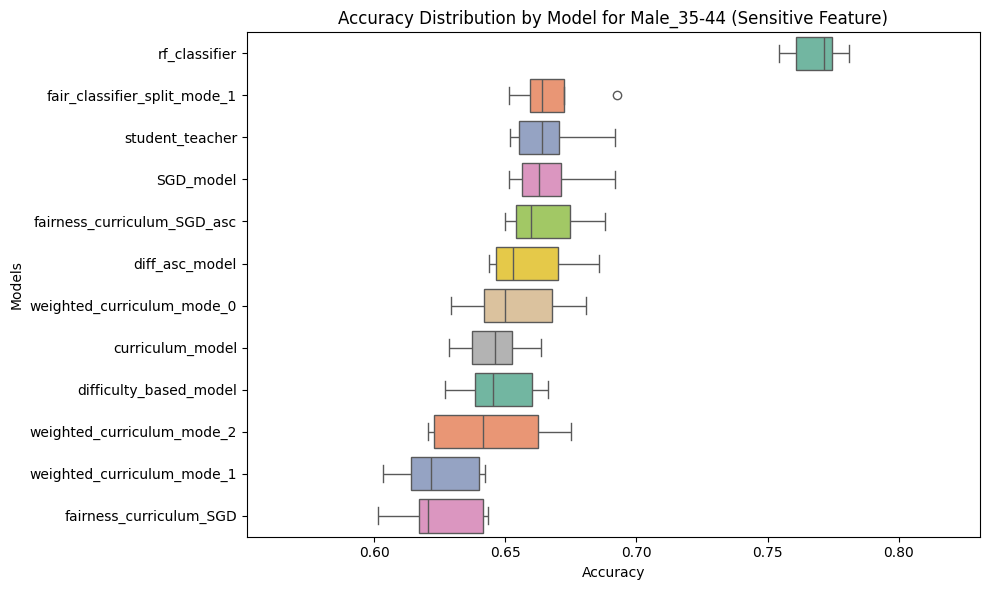

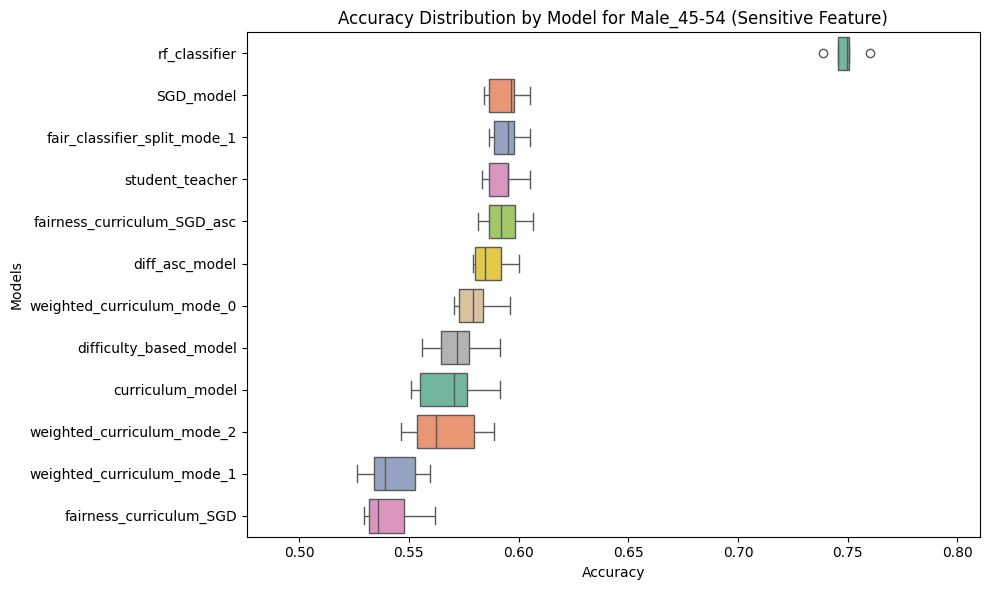

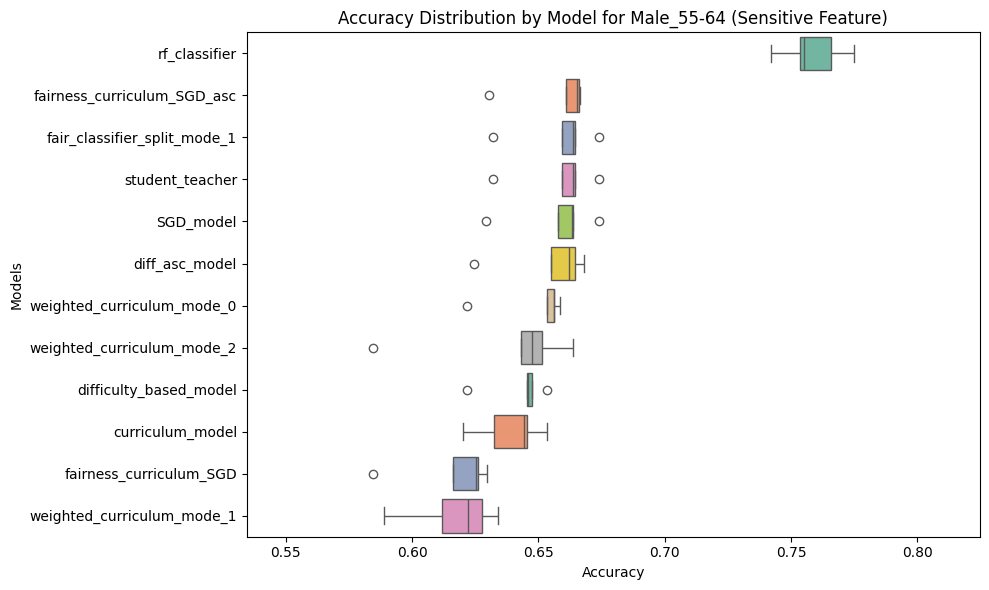

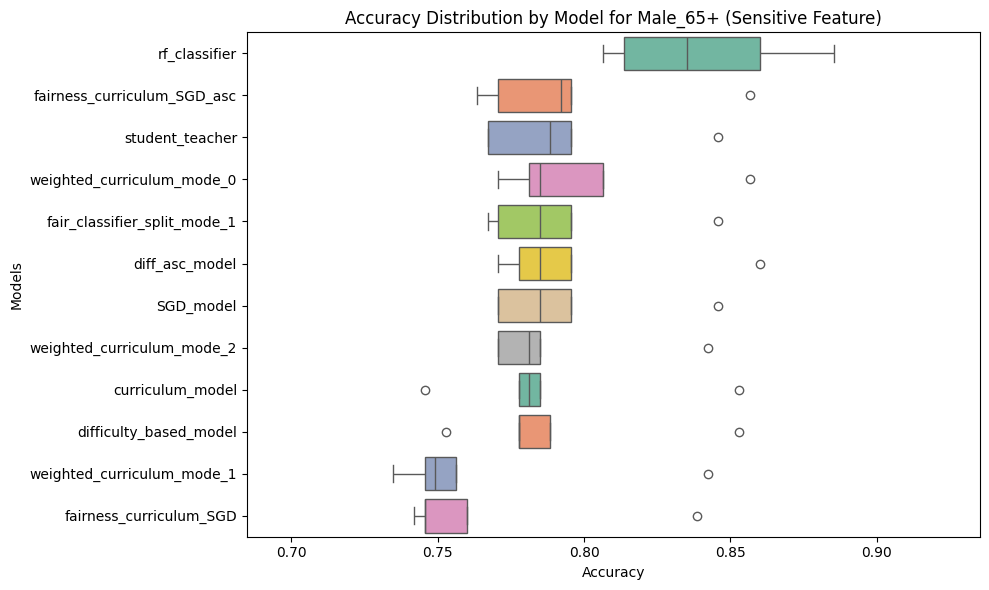

In [34]:
# Plot per-group accuracy distributions
evaluator.plot_group_accuracies(label_encoder=label_encoders['gender_age_class'])

# Race and Gender as a Sensitive feature

In [36]:
data = fetch_adult(as_frame=True)
df = data.frame



df['gender_race'] = df['sex'].astype(str) + "_" + df['race'].astype(str)

# To confirm the sensitive feature, you can check the distribution of the combined sensitive feature
print("Distribution of 'gender_age_class' sensitive feature:")
print(df['gender_race'].value_counts())


# Preprocessing: Encode categorical variables
label_encoders = {}
for col in ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'gender_race']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le



# Features and labels
X = df.drop(columns=['class'])
y = (df['class'] == '>50K').astype(int)  # Binary target: 1 if >50K, else 0
z = df['gender_race']  # Combined sensitive attribute (gender + age_class)

# Stratified K-Fold Split (stratified by combined sensitive feature 'gender_age_class')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

folds = []
for fold_idx, (train_idx, test_idx) in enumerate(skf.split(X, z)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    z_train, z_test = z.iloc[train_idx], z.iloc[test_idx]
    folds.append((X_train, X_test, y_train, y_test, z_train, z_test))


Distribution of 'gender_age_class' sensitive feature:
gender_race
Male_White                   28735
Female_White                 13027
Male_Black                    2377
Female_Black                  2308
Male_Asian-Pac-Islander       1002
Female_Asian-Pac-Islander      517
Male_Amer-Indian-Eskimo        285
Male_Other                     251
Female_Amer-Indian-Eskimo      185
Female_Other                   155
Name: count, dtype: int64


In [37]:
predictions = train_and_predict_with_sensitive_feature(folds, sensitive_feature='gender_race')

Training on fold 1...
Min accuracy group: 2
Min accuracy group: 9
Predicting on fold 1...
Fold 1 complete.

Training on fold 2...
Min accuracy group: 7
Min accuracy group: 7
Predicting on fold 2...
Fold 2 complete.

Training on fold 3...
Min accuracy group: 7
Min accuracy group: 7
Predicting on fold 3...
Fold 3 complete.

Training on fold 4...
Min accuracy group: 7
Min accuracy group: 7
Predicting on fold 4...
Fold 4 complete.

Training on fold 5...
Min accuracy group: 7
Min accuracy group: 4
Predicting on fold 5...
Fold 5 complete.



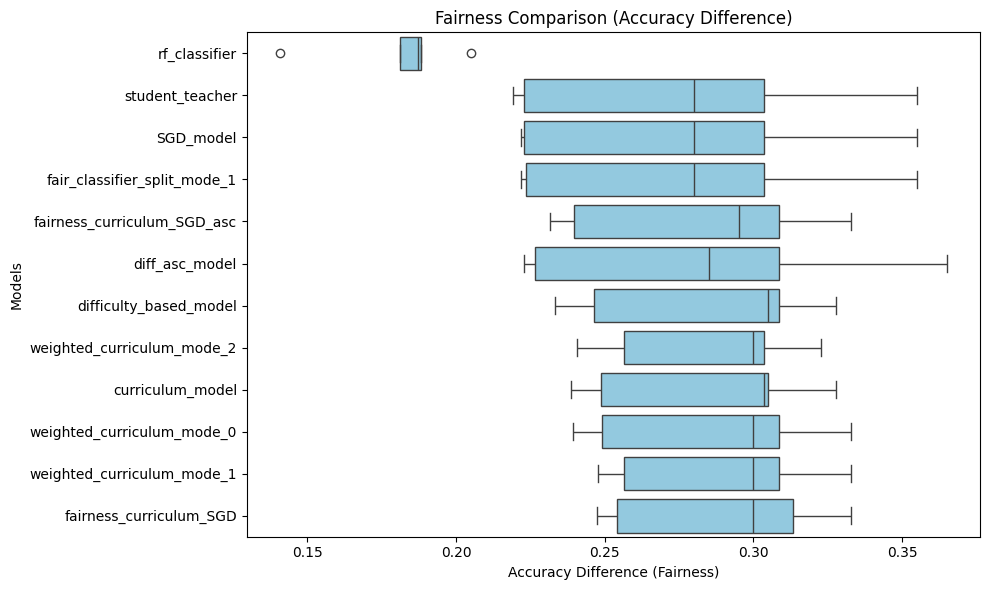

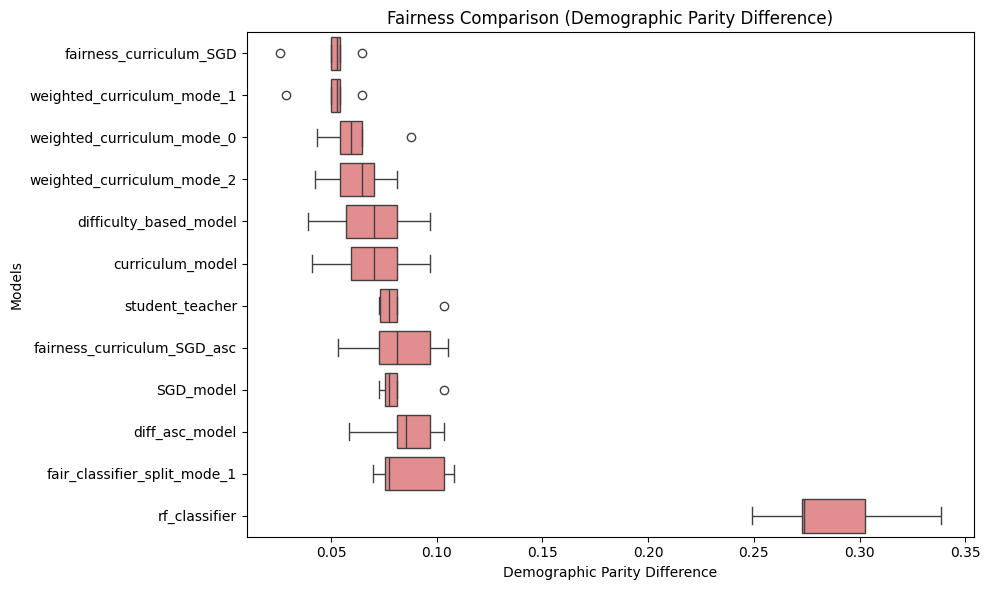

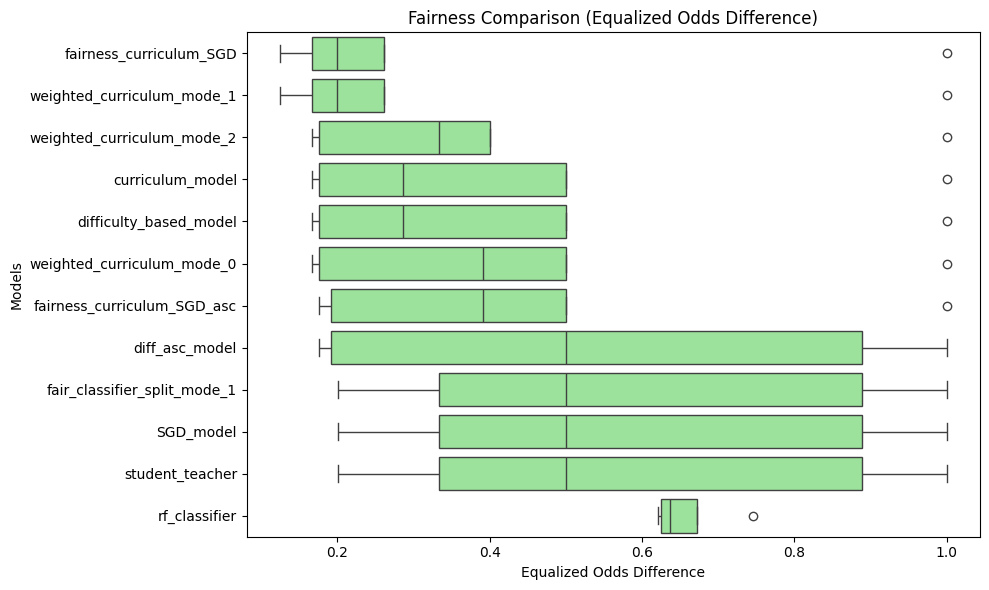

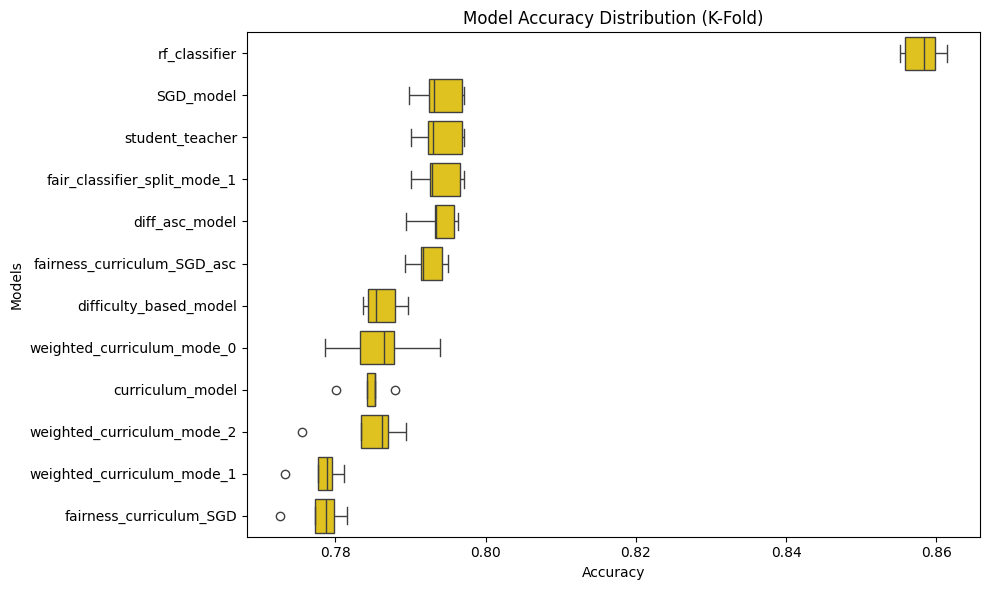

In [38]:
# Instantiate the fairness evaluator
evaluator = FairnessEvaluatorHelper(folds, predictions)

# Compute all fairness metrics
evaluator.compute_fairness_metrics()

# Plot sorted fairness metrics
evaluator.plot_accuracy_differences()
evaluator.plot_demographic_parity()
evaluator.plot_equalized_odds()
evaluator.plot_accuracies()

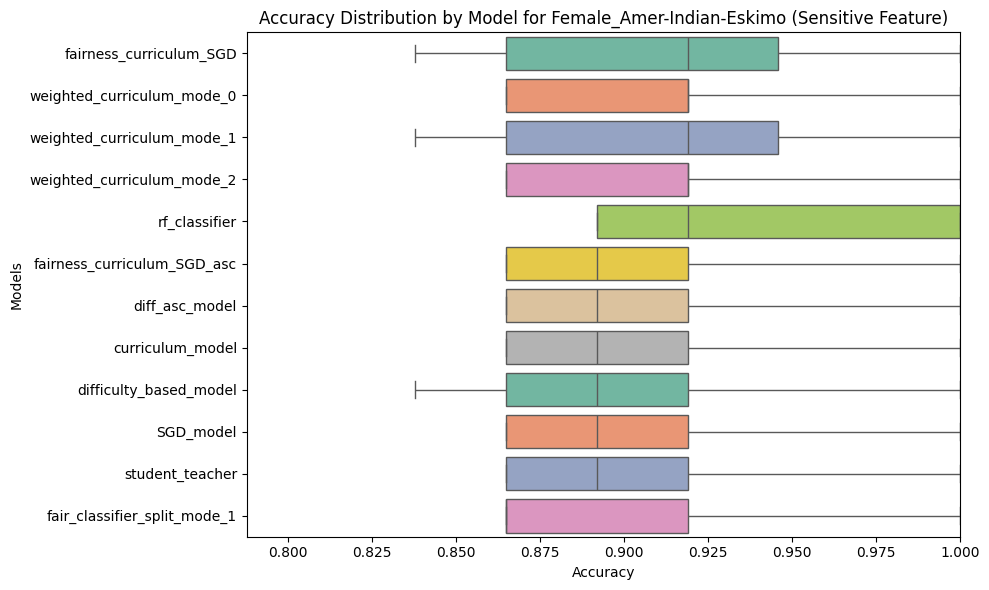

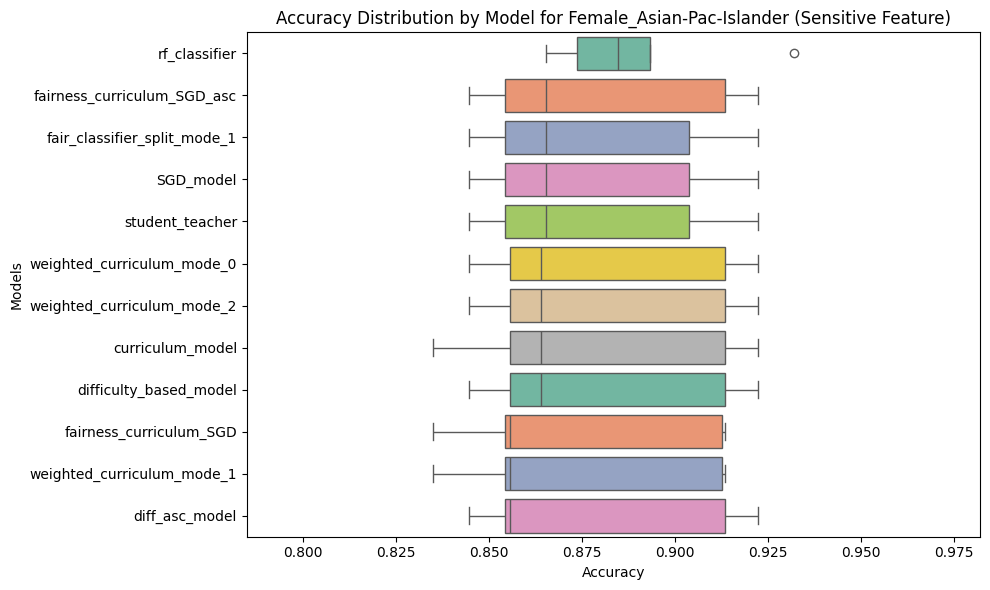

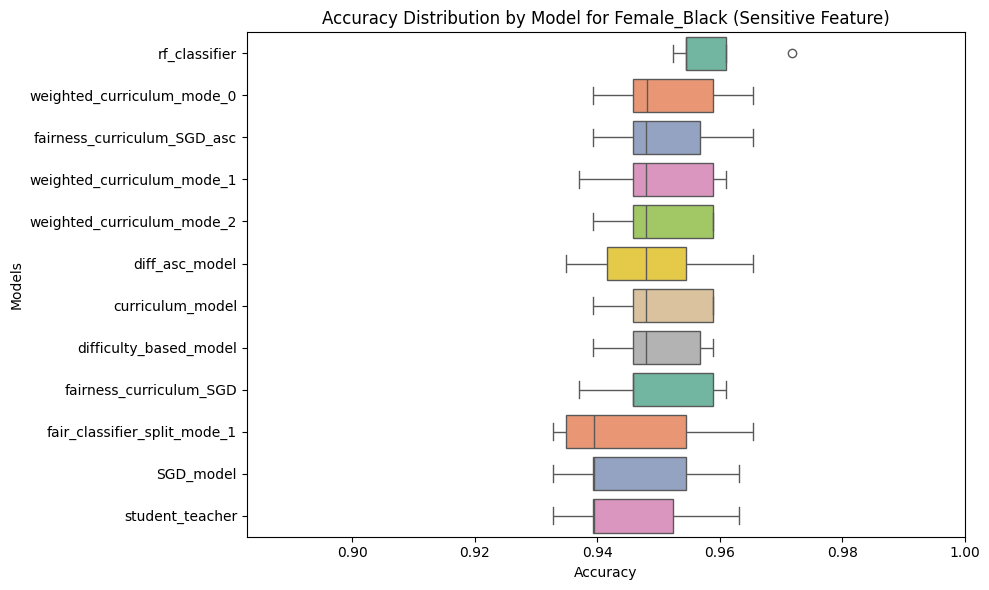

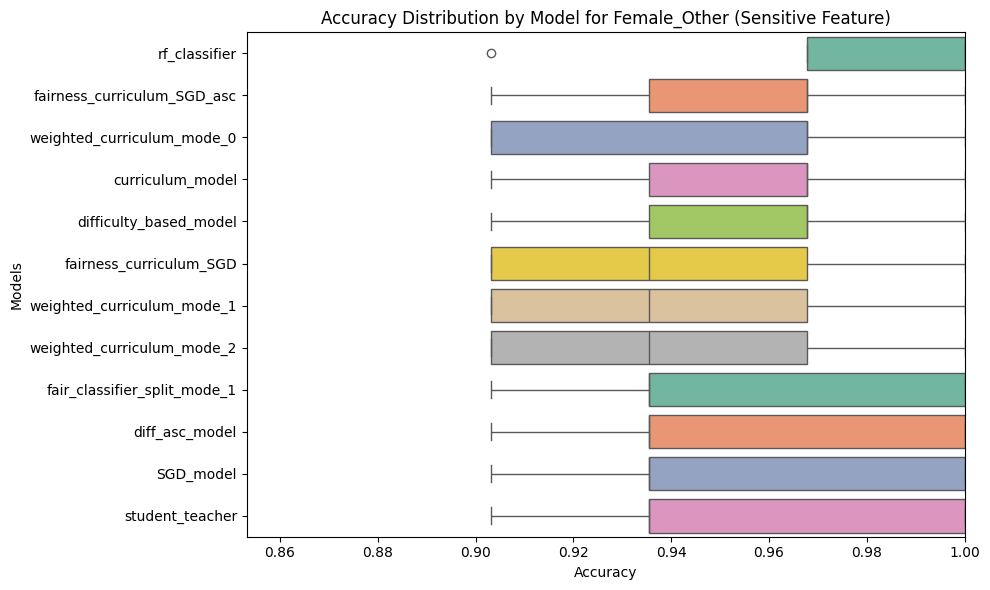

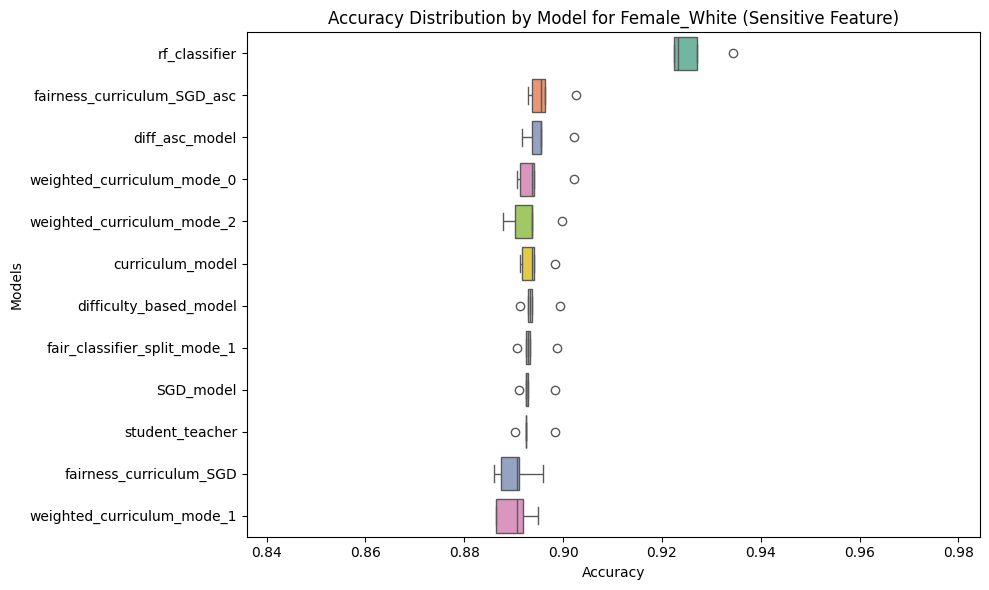

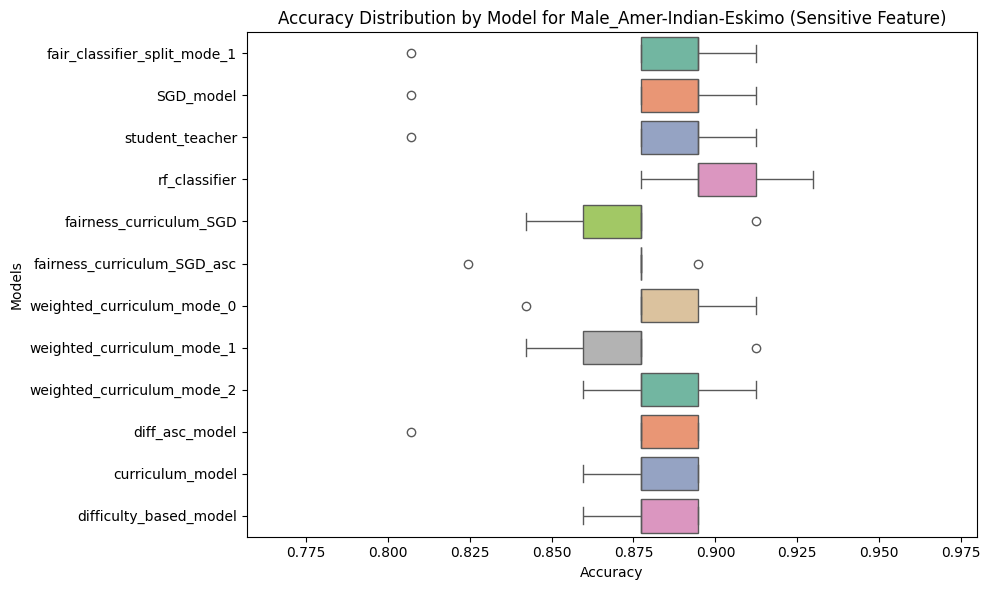

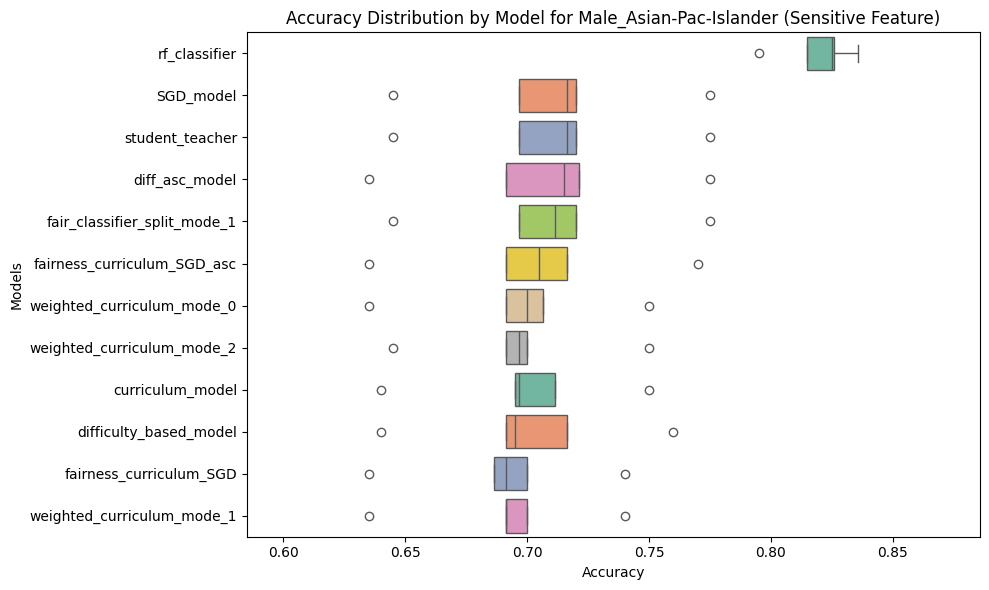

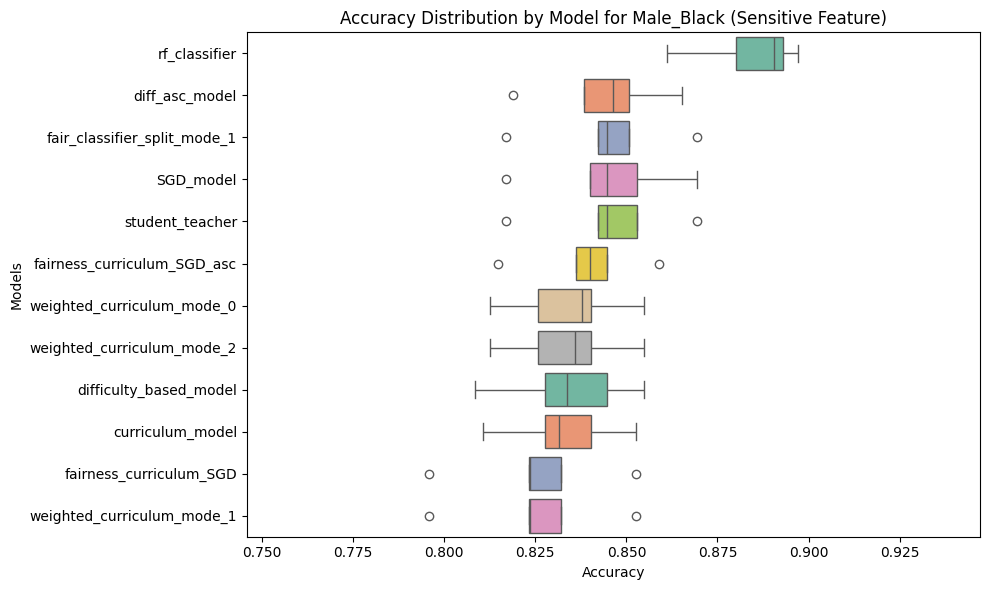

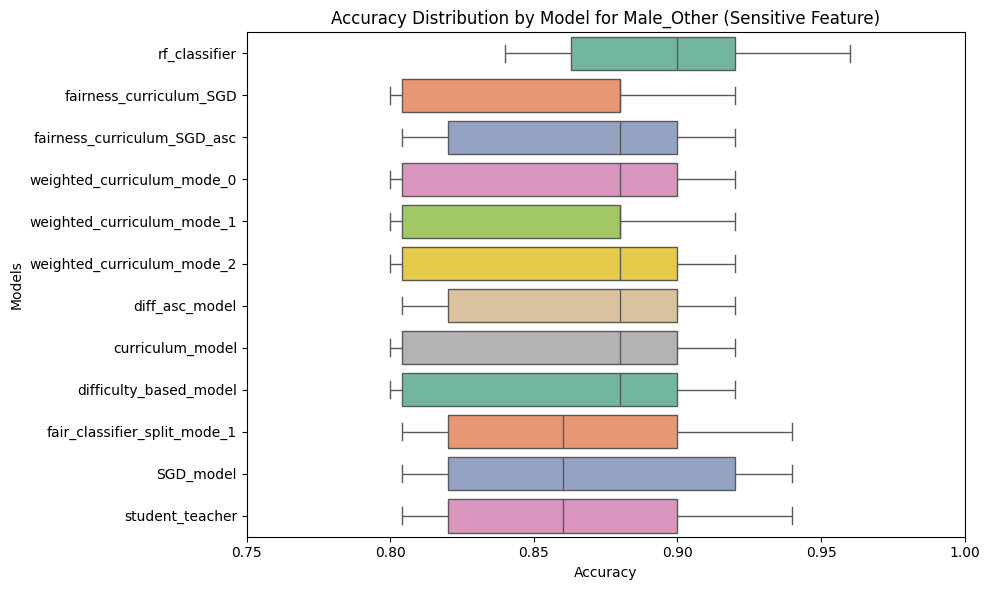

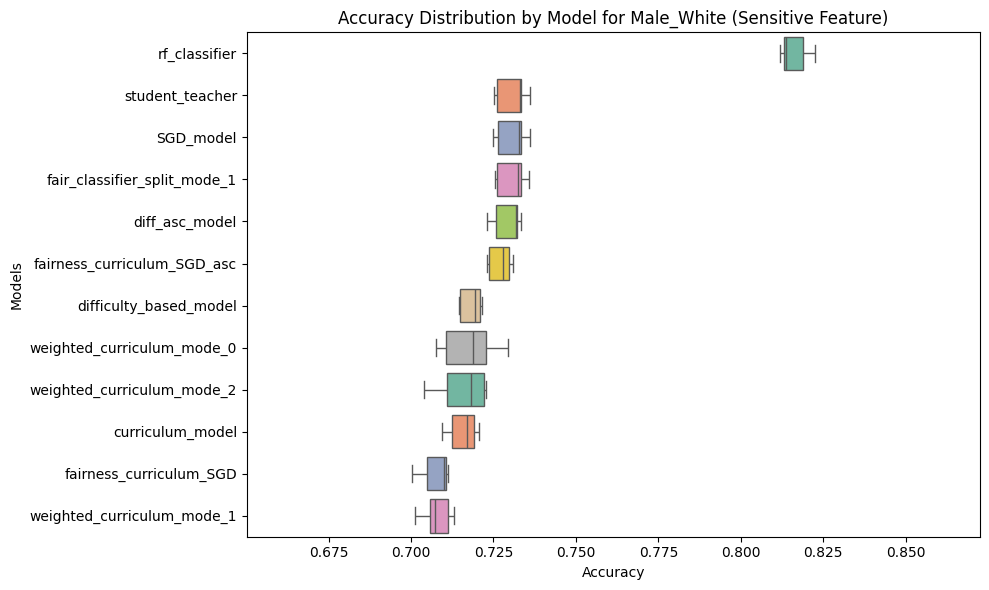

In [39]:
# Plot per-group accuracy distributions
evaluator.plot_group_accuracies(label_encoder=label_encoders['gender_race'])